In [22]:
import numpy as np
from math import exp
import random
import plotly.graph_objects as go
from scipy.interpolate import make_smoothing_spline
from sklearn.metrics import mean_squared_error
from matplotlib.backends.backend_pdf import PdfPages

## 1. Dataset generation

In [23]:
def generate_dataset(n_samples: int) -> list[list[float]]:
    
    X, g_x, y_noise = [], [], []
    
    for _ in range(n_samples):
        x = random.uniform(0, 4)
        X.append(x)
        
        g_func = lambda x: 4.26 * (exp(-1 * x) - 4 * exp(-2 * x) + 3 * exp(-3 * x))
        g_x.append(g_func(x))
        
        epsilon = np.random.normal(0, 0.1)
        
        y_noise.append(g_func(x) + epsilon)
    
    return X, g_x, y_noise

In [24]:
X, g_x, y_noise = generate_dataset(400)

In [25]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=X, y=g_x, mode='markers', name='g(x)'))
fig.add_trace(go.Scatter(x=X, y=y_noise, mode='markers', name='g(x) with noise'))

fig.update_layout(title='Visualizing the generated data')
fig.show()

## 2. Implement Nadaraya-Watson kernel regression

In [26]:
def kernel_regression(x, y, xi, smoothing_parameter = 0.2):
    
    def gaussian(x: float, mu: int = 0, h: int = 1) -> float:
        return (
            1 / (h * np.sqrt(2 * np.pi)) *
            np.exp(-np.square((x - mu) / h) / 2)
        )
        
    weights = []
    
    for el in range(len(x)):
       kernel_func = gaussian((x[el]-xi) / smoothing_parameter)
       weights.append(kernel_func / smoothing_parameter) 
    
    result = []
    
    for el in range(len(x)):
        result.append(weights[el] * y[el])

    return sum(result) / sum(weights)

## 3. Compare performace of two algorithms:
* Nadaraya-Watson kernel regression
* Smoothing Splines regression

### Nadaraya-Watson kernel regression results

In [27]:
smoothing_parameters = [0.01, 0.1, 0.2]
X, g_x, y_noise = generate_dataset(400)

all_kernel_results = []

for smooth_param in smoothing_parameters:
    nadaraya_watson = [kernel_regression(X, y_noise, x, smooth_param) for x in X]
    mse = mean_squared_error(g_x, nadaraya_watson)
    res = {'smoothing_parameter': smooth_param,
           'nadaraya_watson': nadaraya_watson,
           'mse': mse}
    all_kernel_results.append(res)
    

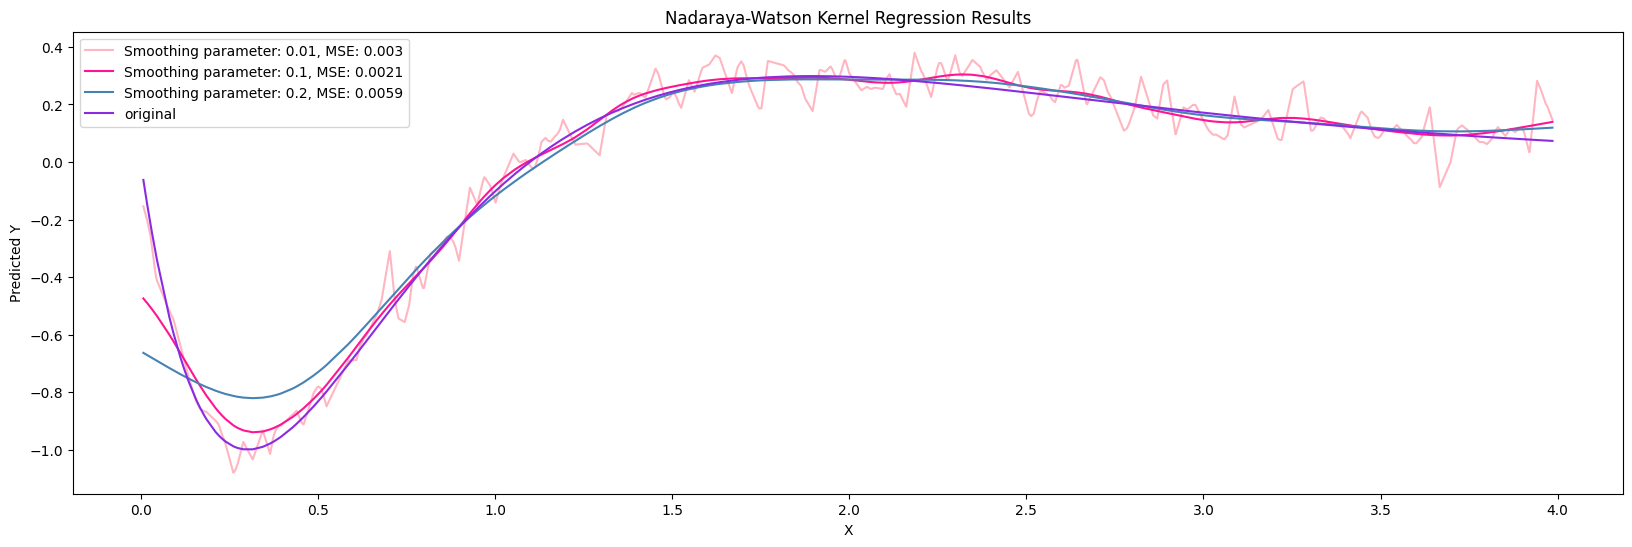

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 6))

colors = ['#FFB6C1', '#FF1493', '#4682B4', '#8A2BE2']

# Plot each result
for color, result in zip(colors, all_kernel_results):
    y_pred = result['nadaraya_watson']
    smooth_param = result['smoothing_parameter']
    mse = result['mse']
    sns.lineplot(x=X, y=y_pred, label=f'Smoothing parameter: {smooth_param}, MSE: {round(mse, 4)}', color=color)

sns.lineplot(x=X, y=g_x, label=f'original', color=colors[-1])

# Add title and labels
plt.title('Nadaraya-Watson Kernel Regression Results')
plt.xlabel('X')
plt.ylabel('Predicted Y')
plt.legend()

# Show the plot
plt.show()

### Smoothing Splines results

In [29]:
smoothing_splines_results = []
smoothing_parameters = [0.01, 0.1, 0.2]

# Sort X and reorder y_noise and g_x based on sorted indices of X
sorted_indices = np.argsort(X)
X_sorted = np.array(X)[sorted_indices]
y_noise_sorted = np.array(y_noise)[sorted_indices]
g_x_sorted = np.array(g_x)[sorted_indices]


for smooth_param in smoothing_parameters:
       spline = make_smoothing_spline(X_sorted, y_noise_sorted, lam=smooth_param)
       smoothing_splines = spline(X_sorted)
       mse = mean_squared_error(g_x_sorted, smoothing_splines)
       res = {'smoothing_parameter': smooth_param,
              'smoothing_splines': smoothing_splines,
              'mse': mse}
       smoothing_splines_results.append(res)
    

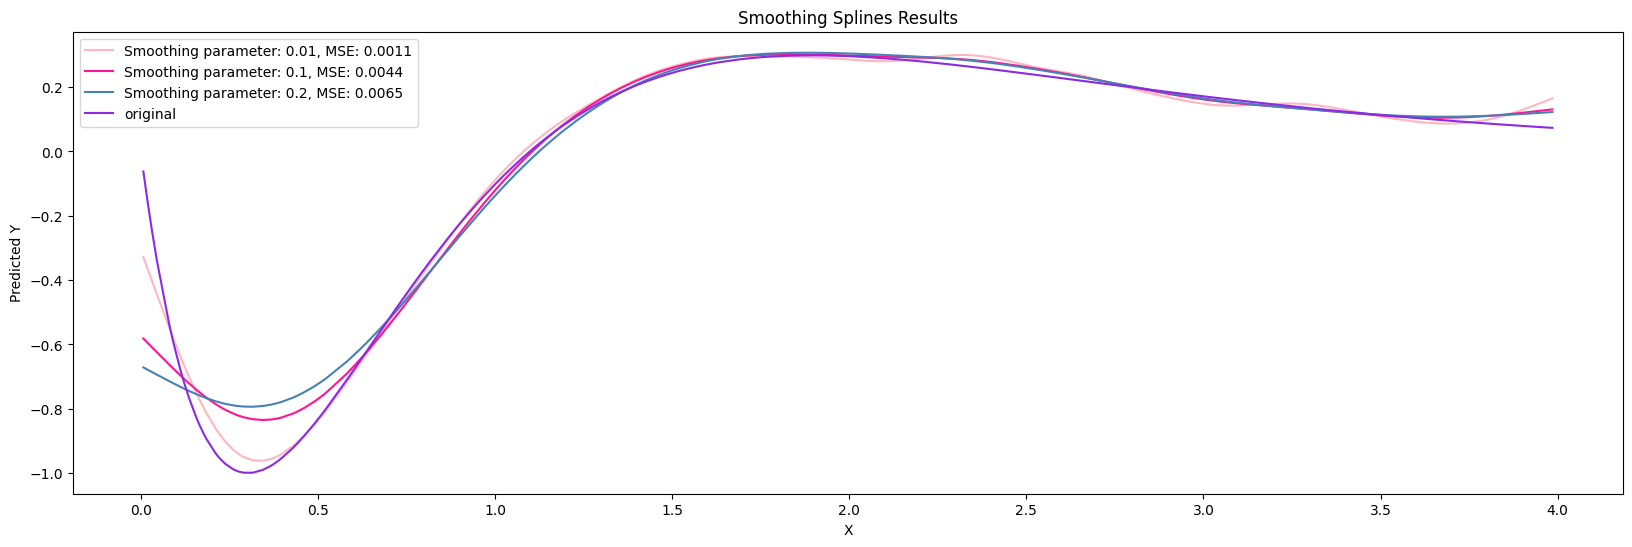

In [30]:
plt.figure(figsize=(20, 6))

colors = ['#FFB6C1', '#FF1493', '#4682B4', '#8A2BE2']

# Plot each result
for color, result in zip(colors, smoothing_splines_results):
    y_pred = result['smoothing_splines']
    smooth_param = result['smoothing_parameter']
    mse = result['mse']
    sns.lineplot(x=X_sorted, y=y_pred, label=f'Smoothing parameter: {smooth_param}, MSE: {round(mse, 4)}', color=color)

sns.lineplot(x=X, y=g_x, label=f'original', color=colors[-1])

# Add title and labels
plt.title('Smoothing Splines Results')
plt.xlabel('X')
plt.ylabel('Predicted Y')
plt.legend()

# Show the plot
plt.show()

## 4. Visualize the results

In [38]:
# Generate dataset
X, g_x, y_noise = generate_dataset(400)

# Kernel regression
nadaraya_watson = [kernel_regression(X, y_noise, x, 0.1) for x in X]
mse_regression = mean_squared_error(g_x, nadaraya_watson)

# Smoothing splines
sorted_indices = np.argsort(X)
X_sorted = np.array(X)[sorted_indices]
y_noise_sorted = np.array(y_noise)[sorted_indices]
g_x_sorted = np.array(g_x)[sorted_indices]

spline = make_smoothing_spline(X_sorted, y_noise_sorted, lam=0.01)
smoothing_splines = spline(X_sorted)
mse_ssplines = mean_squared_error(g_x_sorted, smoothing_splines)

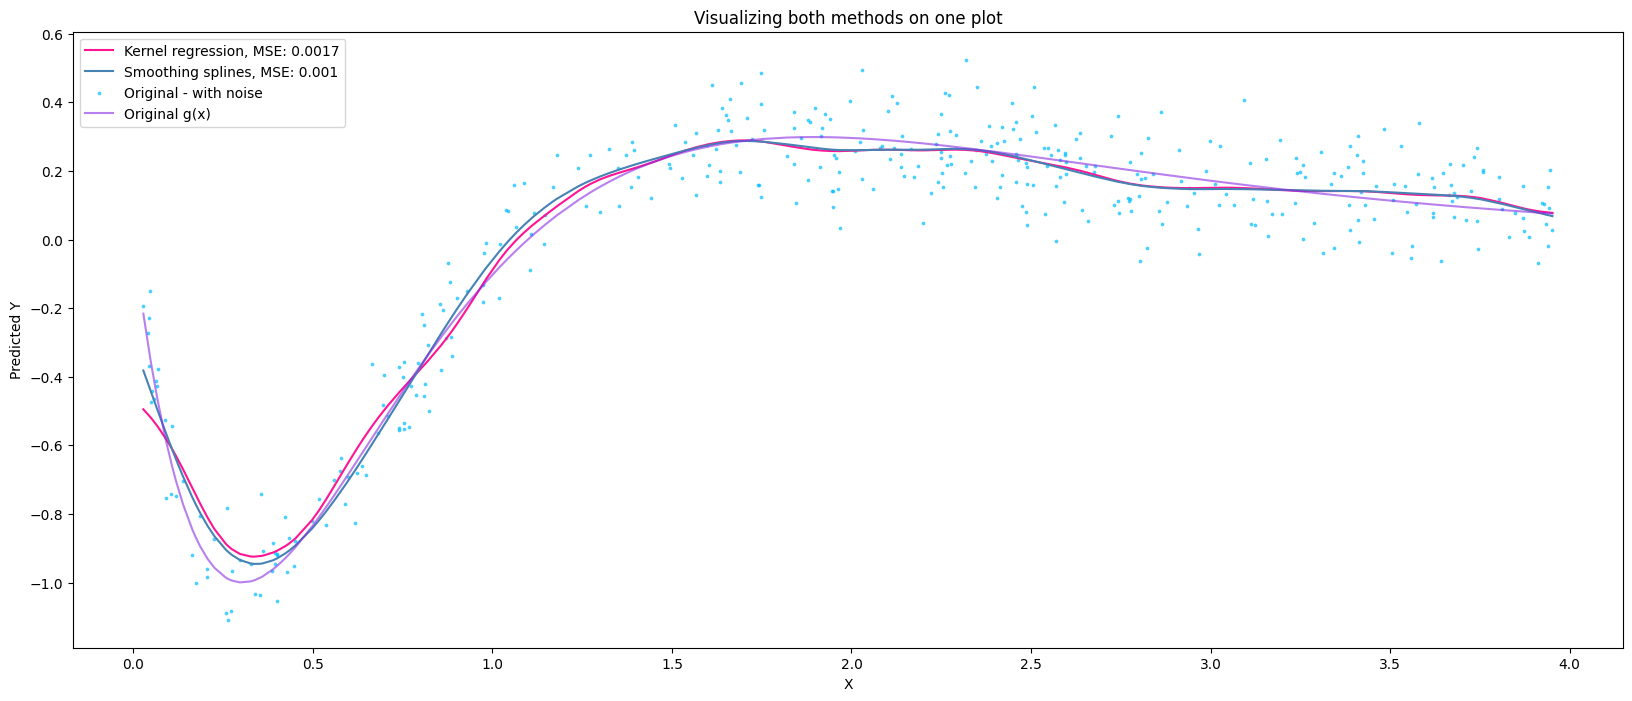

In [39]:
# Create a figure
plt.figure(figsize=(20, 8))

sns.lineplot(x=X, y=nadaraya_watson, label=f'Kernel regression, MSE: {round(mse_regression, 4)}', color='#FF1493')
sns.lineplot(x=X_sorted, y=smoothing_splines, label=f'Smoothing splines, MSE: {round(mse_ssplines, 4)}', color='#4682B4')

plt.scatter(X, y_noise, label='Original - with noise', color='deepskyblue', alpha=0.6, s=3)
sns.lineplot(x=X, y=g_x, label='Original g(x)', color='#8A2BE2', alpha=0.6)

# Add title and labels
plt.title('Visualizing both methods on one plot')
plt.xlabel('X')
plt.ylabel('Predicted Y')
plt.legend()

plt.show()

### Saving to pdf

In [43]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages("PLOT1.pdf") as pdf:
    
    # --------------------
    # General plot
    plt.figure(figsize=(20, 8))

    sns.lineplot(x=X, y=nadaraya_watson, label=f'Kernel regression, MSE: {round(mse_regression, 4)}', color='#FF1493')
    sns.lineplot(x=X_sorted, y=smoothing_splines, label=f'Smoothing splines, MSE: {round(mse_ssplines, 4)}', color='#4682B4')

    plt.scatter(X, y_noise, label='Original - with noise', color='deepskyblue', alpha=0.6, s=3)
    sns.lineplot(x=X, y=g_x, label='Original g(x)', color='#8A2BE2', alpha=0.6)

    # Add title and labels
    plt.title('Visualizing both methods on one plot')
    plt.xlabel('X')
    plt.ylabel('Predicted Y')
    plt.legend()

    pdf.savefig()
    plt.close()

    # -------------------------
    # Version of scatter plot
    plt.figure(figsize=(20, 8))

    plt.scatter(x=X, y=nadaraya_watson, label=f'Kernel regression, MSE: {round(mse_regression, 4)}', color='#FF1493', s=3)
    plt.scatter(x=X_sorted, y=smoothing_splines, label=f'Smoothing splines, MSE: {round(mse_ssplines, 4)}', color='#4682B4', s=3)

    plt.scatter(X, y_noise, label='Original - with noise', color='deepskyblue', alpha=0.6, s=3)
    plt.scatter(x=X, y=g_x, label='Original g(x)', color='#8A2BE2', alpha=0.6, s=3)

    # Add title and labels
    plt.title('Visualizing both methods on one scatter plot')
    plt.xlabel('X')
    plt.ylabel('Predicted Y')
    plt.legend()

    pdf.savefig()
    plt.close()


## 5. Compute MSE

In [32]:
def calculate_mse(sample_size):
    # Generate dataset
    X, g_x, y_noise = generate_dataset(sample_size)

    # Kernel regression
    nadaraya_watson = [kernel_regression(X, y_noise, x, 0.1) for x in X]
    mse_regression = (mean_squared_error(g_x, nadaraya_watson))
    
    # Smoothing splines
    sorted_indices = np.argsort(X)
    X_sorted = np.array(X)[sorted_indices]
    y_noise_sorted = np.array(y_noise)[sorted_indices]
    g_x_sorted = np.array(g_x)[sorted_indices]

    spline = make_smoothing_spline(X_sorted, y_noise_sorted, lam=0.01)
    smoothing_splines = spline(X_sorted)
    mse_ssplines = mean_squared_error(g_x_sorted, smoothing_splines)
    
    return mse_regression, mse_ssplines

In [33]:
all_mse_regression = []
all_mse_ssplines = []

for _ in range(20):
    mse_regression, mse_ssplines = calculate_mse(400)
   
    all_mse_regression.append(mse_regression)
    all_mse_ssplines.append(mse_ssplines)

print(f'Mean MSE for Nadaraya Watson Kernel Regression: {round(np.mean(all_mse_regression), 5)}')
print(f'Mean MSE for Smoothing Splines: {round(np.mean(all_mse_ssplines), 5)}')


Mean MSE for Nadaraya Watson Kernel Regression: 0.00213
Mean MSE for Smoothing Splines: 0.00096


## 6. Explore how the MSE depends on sample size 

In [36]:
sample_sizes = [100, 200, 400, 800, 1000]
all_mse_regression = []
all_mse_ssplines = []

for sample_size in sample_sizes:
    
    mse_regression_size = []
    mse_ssplines_size = []
    
    for _ in range(10):
        mse_regression, mse_ssplines = calculate_mse(sample_size)
    
        mse_regression_size.append(mse_regression)
        mse_ssplines_size.append(mse_ssplines)

    all_mse_regression.append(np.mean(mse_regression_size))
    all_mse_ssplines.append(np.mean(mse_ssplines_size))


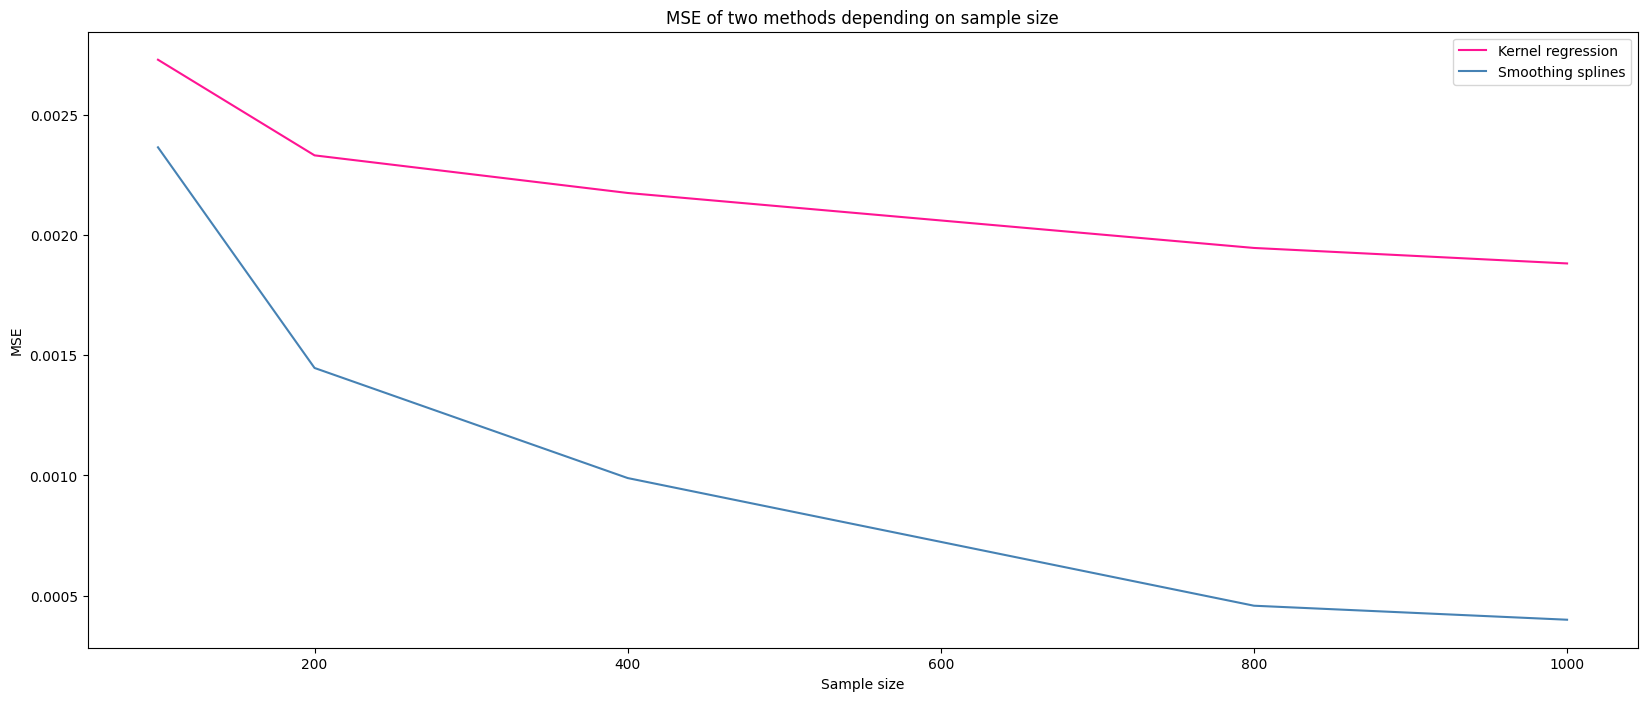

In [40]:
# Create a figure
plt.figure(figsize=(20, 8))

sns.lineplot(x=sample_sizes, y=all_mse_regression, label=f'Kernel regression', color='#FF1493')
sns.lineplot(x=sample_sizes, y=all_mse_ssplines, label=f'Smoothing splines', color='#4682B4')

# Add title and labels
plt.title('MSE of two methods depending on sample size')
plt.xlabel('Sample size')
plt.ylabel('MSE')
plt.legend()

plt.savefig('PLOT2.pdf')

plt.show()